### DataFrame Readers

In [3]:
# df reader for sleep data
def sleep_dataset_reader(str_dataset):
    ''' This function takes a string of location of sleep csv and properly formats it to be read as a dataframe.
    Parameters: String, which is the location of the sleep dataset
    Returns: Returns a dataframe with proper format; dataframe does not extend past header columns
    '''
    test = open('scripps1_sleep.csv','r')
    lines = test.readlines()
    length_lines = [len(x.strip().split(';')) for x in lines]
    columns = max(length_lines) 
    list_rows = [] 
    list_sleep_phases = [] 
    for i in lines: 
        list_rows.append(i.strip().split(';'))
        list_sleep_phases.append(i.strip().split(';')[39:])
    list_rows[0].extend(range(len(list_rows[0])-39,columns-39))
    list_rows[0] = list(map(str, list_rows[0]))
    for row in list_rows:
            row.extend(np.nan for x in range(columns-len(row))) # extends rows; for some, 'sleep cycle max' is less than 899
    headers = list_rows.pop(0)
    df = pd.DataFrame(list_rows,columns = headers,dtype='float')
    df.replace(r'^\s*$', np.nan, regex=True, inplace = True) # replaces all the empty spaces with NaN 
    df['list_numbers'] = list_sleep_phases[1:]
    return df

# df reader for motion data 
def motion_dataset_reader(str_dataset):
    return pd.read_csv('scripps1_motion.csv',sep=';')

# df reader for ibi data 
def ibi_dataset_reader(str_dataset):
    return pd.read_csv('scripps1_ibi.csv',sep=';')

In [4]:
# examples of methods being used
sleep_data = sleep_dataset_reader('scripps1_sleep.csv')
motion_data = motion_dataset_reader('scripps1_motion.csv')
ibi_data = ibi_dataset_reader('scripps1_ibi.csv')

In [47]:
sleep_data.head()

,Date,Bedtime start Unix,Bedtime end Unix,Bedtime start,Bedtime end,TimeZone,Debug info,Battery consumption,Is longest,Time in bed,...,1731,1732,1733,1734,1735,1736,1737,1738,1739,list_numbers
0,27.11.2018,1.543351e+09,1.543352e+09,12:35:53,12:49:53,-8.0,NaN,NaN,1.0,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, ..."
1,27.11.2018,1.543368e+09,1.543369e+09,17:17:55,17:37:55,-8.0,NaN,NaN,1.0,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
2,28.11.2018,1.543386e+09,1.543419e+09,22:16:15,7:32:15,-8.0,NaN,1.2%,1.0,556.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
3,28.11.2018,1.543438e+09,1.543440e+09,12:52:26,13:12:26,-8.0,NaN,NaN,0.0,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, ..."
4,29.11.2018,1.543463e+09,1.543464e+09,19:44:43,19:54:43,-8.0,NaN,NaN,1.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


# Sleep Dataset Methods

In [42]:
# methods for the sleep dataset created from sleep_dataset_reader()
# dataset cleaner
def dataset_cleaner(dataset):
    '''This function does a general clean of the sleep dataframe (changes variables to proper types, drops
    unimportant columns)
    Parameter: dataset, the sleep dataframe 
    Returns: Returns a cleaner dataframe that has proper dtypes and less unnecessary columns 
    
    WHAT'S NEEDED: TimeZone is unclear. For future reference, what the numbers are might be useful
    '''
    df = dataset.copy()
    df['Date'] =  pd.to_datetime(df['Date'], format='%d.%m.%Y') 
    # originally string, might be unnecessary? maybe convert to date; weekday vs weekend?
    df['Bedtime start Unix'] = pd.to_datetime(df['Bedtime start Unix'],unit='s') # originally string
    df['Bedtime end Unix'] = pd.to_datetime(df['Bedtime end Unix'],unit='s') # originally string 
    df = df.drop(['Bedtime start','Bedtime end'],axis=1) # unnecessary, since we already have bedtime unix's
    df = df[df['Debug info'] != 'Bedtime detection failed'] 
    # removes bedtime detection failed, rows lack info; line could be used to grab failing measurements in the future 
    str_list = list(filter(None, list(df.columns))) 
    # some columns have empty header and are empty, this gets rid of these columns 
    return df[str_list]

def no_sleep_phases(df):
    ''' Method used to split dataframe into initial interest columns first. Focuses on only the first few 
    columns, ignoring the sleep phases columns. Hopefully I can get some more information about those later on 
    Parameter: df, the cleaned sleep dataframe 
    Returns: returns dataframe with columns of interest, everything should be converted to numbers 
    
    THINGS TO CONSIDER: Maybe don't drop bed time/wake time. Could be something important (sleeping late at night
    vs sleeping earlier, etc.)
    '''
    df = dataset_cleaner(df)
    area_interest = df.iloc[:,6:35].dropna(how='all', axis=1).drop('SleepMidPoint',axis=1)
    return area_interest.apply(pd.to_numeric)

def correlation_graph(df):
    df = no_sleep_phases(df)
    corr = df.corr()
    f = plt.figure(figsize=(10,10))
    ax = f.add_subplot(111)
    ax = sns.heatmap(
        corr, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
    )
    ax.set_title('Correlation Plot of Sleep Variables (Not including sleep phases)');
    return ax

def naps_and_sleep(df):
    ''' Method used to split dataframe into two dataframes; one focused on naps (sleep minutes less than 30 
    minutes) and one focused on concrete sleep (sleep minutes equal to or more than 30 minutes)
    Parameter: df, the cleaned sleep dataframe 
    Returns: returns two dataframes, first one being naps (naps dataframe), second one being sleep (sleep dataframe)
    
    POTENTIAL SOURCE: https://www.sleep.org/articles/how-long-to-nap/
    '''
    df = dataset_cleaner(df)
    naps = df[df['Sleep minutes']<30]
    sleep = df[df['Sleep minutes']>=30]
    return naps,sleep

def sleep_duration_vs_sleep_plot(df,interest_in_naps=False,interest_in_sleep=False):
    naps, sleep = naps_and_sleep(df)
    f, ax = plt.subplots()
    if (not interest_in_naps and not interest_in_sleep):
        ax.scatter('Sleep minutes', 'Sleep Score', data = df, color='g',label='All Sleep Measurements')
    if interest_in_sleep:
        ax.scatter('Sleep minutes', 'Sleep Score', data = sleep, color='r',label='Sleep')
        if not interest_in_naps:
            ax.plot(np.unique(sleep['Sleep minutes']), np.poly1d(np.polyfit(sleep['Sleep minutes'], sleep['Sleep Score']
                                                                    , 1))(np.unique(sleep['Sleep minutes'])),color='r')
    if interest_in_naps:
        ax.scatter('Sleep minutes', 'Sleep Score', data = naps, color='b',label='Naps')
        if not interest_in_sleep:
            ax.plot(np.unique(naps['Sleep minutes']), np.poly1d(np.polyfit(naps['Sleep minutes'], naps['Sleep Score']
                                                                    , 1))(np.unique(naps['Sleep minutes'])),color='b')
    ax.set_ylabel('Sleep Score')
    ax.set_xlabel('Sleep Duration (minutes)')
    ax.set_title('Sleep Duration vs. Sleep Score')
    leg = ax.legend();
    return ax

def bedtime_start_vs_sleep_plot(df,interest_in_naps=False,interest_in_sleep=False):
    naps, sleep = naps_and_sleep(df)
    f, ax = plt.subplots()
    if (not interest_in_naps and not interest_in_sleep):
        ax.scatter(df['Bedtime start Unix'].astype(int), 'Sleep Score', data = df,color='g',label='All Sleep Measurements')
    if interest_in_sleep:
        ax.scatter(sleep['Bedtime start Unix'].astype(int).sort_values(), 'Sleep Score', data = sleep,color='r',label='Sleep')
        ax.plot(sleep['Bedtime start Unix'].astype(int), np.poly1d(np.polyfit(sleep['Bedtime start Unix'].astype(int), sleep['Sleep Score']
                                                                        , 1))(np.unique(sleep['Bedtime start Unix'].astype(int))),color='r')
    if interest_in_naps:
        ax.scatter(naps['Bedtime start Unix'].astype(int).sort_values(), 'Sleep Score', data = naps,color='b',label='Naps')
        ax.plot(naps['Bedtime start Unix'].astype(int), np.poly1d(np.polyfit(naps['Bedtime start Unix'].astype(int), naps['Sleep Score']
                                                                        , 1))(np.unique(naps['Bedtime start Unix'].astype(int))),color='b')
    ax.set_ylabel('Sleep Score')
    ax.set_xlabel('Time')
    #ax.set_xticklabels(df['Bedtime start'].sort_values())
    ax.set_title('Bedtime Start vs. Sleep Score')
    leg = ax.legend();
    return ax

def sleep_phases_vs_sleep_plot(df):
    df_1 = dataset_cleaner(df)
    f, ax = plt.subplots()
    ax.scatter('REM minutes', 'Sleep Score', data = df_1,color='r',label='REM Phase')
    ax.plot(df_1['REM minutes'], np.poly1d(np.polyfit(df_1['REM minutes'], df_1['Sleep Score']
                                                                    , 1))(df_1['REM minutes']),color='r')
    ax.scatter('Light minutes', 'Sleep Score', data = df_1, color='g',label='Light Phase')
    ax.plot(df_1['Light minutes'], np.poly1d(np.polyfit(df_1['Light minutes'], df_1['Sleep Score']
                                                                    , 1))(df_1['Light minutes']),color='g')
    ax.scatter('Deep minutes', 'Sleep Score', data = df_1, color='b',label='Deep Phase')
    ax.plot(df_1['Deep minutes'], np.poly1d(np.polyfit(df_1['Deep minutes'], df_1['Sleep Score']
                                                                    , 1))(df_1['Deep minutes']),color='b')
    ax.set_ylabel('Sleep Score')
    ax.set_xlabel('Duration (minutes)')
    ax.set_title('Duration of Sleep Phases vs. Sleep Score')
    leg = ax.legend();
    return ax

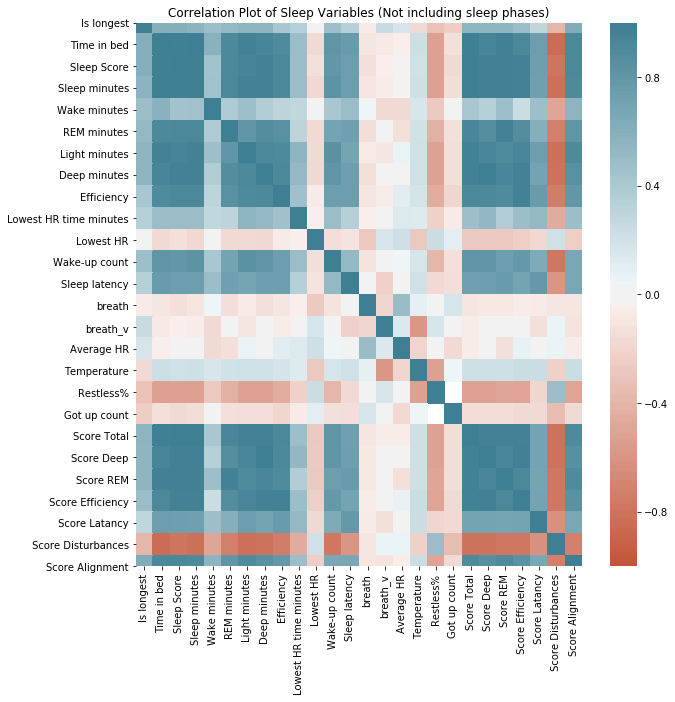

In [15]:
sleep_data = sleep_dataset_reader('scripps1_sleep.csv')
correlation_graph(sleep_data)

If we're purely focused on sleep score, variables of least interest are is_longest, wake_minutes (which makes sense, this should not affect our sleep score), lowest HR time minutes, lowest HR, temp, and get up count. Time in bed and sleep minutes have a big positive correlation, while score disturbances have the biggest negative correlations (assume score disturbances is the number of disturbances?). Obviously scores will have a big effect (score total, score deep, etc.) so those won't need a lot of scrutiny; time in bed, sleep minutes, lengths of sleep in different sleep phases, wake up count, and sleep latency are of biggest interest.

In [25]:
naps,sleep = naps_and_sleep(sleep_data)

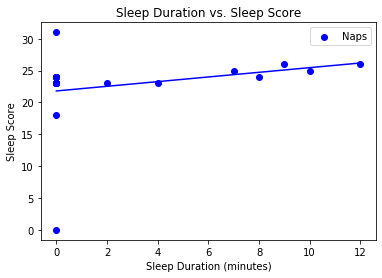

In [26]:
sleep_duration_vs_sleep_plot(sleep_data, interest_in_naps = True, interest_in_sleep = False)

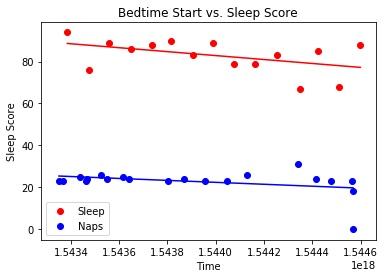

In [43]:
bedtime_start_vs_sleep_plot(sleep_data, interest_in_naps = True, interest_in_sleep = True)

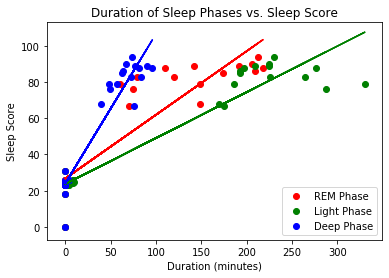

In [150]:
sleep_phases_vs_sleep_plot(sleep_data)